### SRM coverage analysis for p, ph mapping for 'phased' and unphased regions

This notebook is aimed at calculating the coverage of the genome using short read illumina data mapped with bwa againts primary contigs and primary contigs + haplotigs.

* calculate the coverage in 1000 bp sliding windows (200bp) for p and p+h mapping.
* calculate the coverage when mapping against primary contigs in regions with h overlap and without
* plot those out and see

In [28]:
%matplotlib inline

In [10]:
import pandas as pd
import os
import re
from Bio import SeqIO
from Bio import SeqUtils
import pysam
from Bio.SeqRecord import SeqRecord
from pybedtools import BedTool
import numpy as np
import pybedtools
import time
import matplotlib.pyplot as plt
import sys
import subprocess
import shutil
from Bio.Seq import Seq
import pysam
from Bio import SearchIO
import json
import glob
import scipy.stats as stats
import statsmodels as sms
import statsmodels.sandbox.stats.multicomp
import distance
import seaborn as sns
from pybedtools import BedTool
import matplotlib
from sklearn.externals.joblib import Parallel, delayed
import itertools as it
import tempfile
from scipy.signal import argrelextrema
import scipy
from het_cov import *
import importlib

In [54]:
importlib.reload(het_cov)
from het_cov import *

In [56]:
#Define some PATH variables
BASE_AA_PATH = '/home/benjamin/genome_assembly/Warrior/genome_v04'
COV_PATH = '/home/benjamin/genome_assembly/Warrior/COV'
SRM_PATH = os.path.join('/home/benjamin/genome_assembly/Warrior/SRM')

figure_title = 'DK0911 Illumina mapped on DK0911'

genome = 'DK_0911_v04'
mapping_project = "PRI_NTKN_DK0911_on_%s" % genome
pbam_short_fn = 'DK_0911_v03_p_ctg.bwamem.PRI_NTKN_DK0911.sam.sorted.bam'
phbam_short_fn = 'DK_0911_v03_ph_ctg.bwamem.PRI_NTKN_DK0911.sam.sorted.bam'
h_on_p_fn = '/home/benjamin/genome_assembly/Warrior/allele_analysis/v04/allele_analysis/DK_0911_v04_p_ctg.p_by_h_cov.gff'
threads = 6
OUT_PATH = os.path.join(COV_PATH, 'analysis', mapping_project)
if not os.path.exists(OUT_PATH):
    os.makedirs(OUT_PATH)
TMP_PATH = os.path.join(OUT_PATH, 'tmp')
if not os.path.exists(TMP_PATH):
    os.makedirs(TMP_PATH)


In [ ]:
COMB_OUT = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_COV'

Now parallelize the bedtools and samtools functions.
This requires the following:
* split the window bedfile in as many non-overlapping bedfiels as we have threads and return the file locations as in a list.
* a function that takes a two filenames bedfile window and bam file and does a subprocess using samtools 





### Program starts here ###

In [8]:
#define some filenames for assembly files
p_fn = os.path.join(BASE_AA_PATH, '%s_p_ctg.fa' % genome)
ph_fn = os.path.join(BASE_AA_PATH,'%s_ph_ctg.fa' % genome)
p_genome_file_fn = os.path.join(BASE_AA_PATH, '%s_p_ctg.genome_file' % genome)
ph_genome_file_fn = os.path.join(BASE_AA_PATH, \
                                 '%s_ph_ctg.genome_file' % genome)
#and mapping bam files
pbam_fn = os.path.join(SRM_PATH, pbam_short_fn)
phbam_fn = os.path.join(SRM_PATH, phbam_short_fn)

In [12]:
#run some indexing and genome_file commands
faidx_genome(p_genome_file_fn, p_fn)
faidx_genome(ph_genome_file_fn, ph_fn)
h_on_p_sorted_fn = sort_gff_file(h_on_p_fn)

/home/benjamin/genome_assembly/Warrior/genome_v04/DK_0911_v04_p_ctg.genome_file already exists!
/home/benjamin/genome_assembly/Warrior/genome_v04/DK_0911_v04_ph_ctg.genome_file already exists!

Runnning now!

perl /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/get_homologues/gff3sort/gff3sort.pl --precise /home/benjamin/genome_assembly/Warrior/allele_analysis/v04/allele_analysis/DK_0911_v04_p_ctg.p_by_h_cov.gff > /home/benjamin/genome_assembly/Warrior/allele_analysis/v04/allele_analysis/DK_0911_v04_p_ctg.p_by_h_cov.sorted.gff

Done
With ouput:
b''
b''


In [13]:
#now make some window files
p_window_1k200_bed = BedTool().window_maker(g=p_genome_file_fn, w=1000, s=200)
ph_window_1k200_bed = BedTool().window_maker(g=ph_genome_file_fn, w=1000, s=200)
h_on_p_bed = BedTool(fn=h_on_p_sorted_fn)
h_on_p_bed_pos_1k200_bed = p_window_1k200_bed.intersect(h_on_p_bed)
h_on_p_bed_neg_1k200_bed = p_window_1k200_bed.subtract(h_on_p_bed)

In [14]:
#define some outfile names
p_window_1k200_fn = os.path.join(OUT_PATH, '%s_p_ctg.p_window_1k200.cov' % mapping_project)
ph_window_1k200_fn = os.path.join(OUT_PATH, '%s_ph_ctg.ph_window_1k200.cov' % mapping_project)
p_h_on_p_window_1k200_fn = os.path.join(OUT_PATH, \
                                        '%s_ctg.h_on_p.p_window_1k200.cov' %mapping_project)
p_h_not_on_p_window_1k200_fn = os.path.join(OUT_PATH, \
                                        '%s_p_ctg.h_not_on_p.p_window_1k200.cov' %mapping_project)

In [15]:
#save out the bed files for overlaps
p_window_1k200_bed.saveas(p_window_1k200_fn.replace('.cov', '.bed'))
ph_window_1k200_bed.saveas(ph_window_1k200_fn.replace('.cov','.bed'))
h_on_p_bed_pos_1k200_bed.saveas(p_h_on_p_window_1k200_fn.replace('.cov', '.bed'))
h_on_p_bed_neg_1k200_bed.saveas(p_h_not_on_p_window_1k200_fn.replace('.cov', '.bed'))

<BedTool(/home/benjamin/genome_assembly/Warrior/COV/analysis/PRI_NTKN_DK0911_on_DK_0911_v04/PRI_NTKN_DK0911_on_DK_0911_v04_p_ctg.h_not_on_p.p_window_1k200.bed)>

In [16]:
bed_list = [p_window_1k200_fn.replace('.cov', '.bed'), ph_window_1k200_fn.replace('.cov', '.bed'),\
            p_h_on_p_window_1k200_fn.replace('.cov', '.bed'), p_h_not_on_p_window_1k200_fn.replace('.cov', '.bed'),\
           p_h_on_p_window_1k200_fn.replace('.cov', '.bed'), p_h_not_on_p_window_1k200_fn.replace('.cov', '.bed')]
bam_list = [pbam_fn, phbam_fn, phbam_fn, phbam_fn,pbam_fn, pbam_fn]
samcov_list = [p_window_1k200_fn.replace('.cov', '.p_mapping.samcov'), ph_window_1k200_fn.replace('.cov', '.ph_mapping.samcov'),\
              p_h_on_p_window_1k200_fn.replace('.cov', '.ph_mapping.samcov'), p_h_not_on_p_window_1k200_fn.replace('.cov', '.ph_mapping.samcov'),\
              p_h_on_p_window_1k200_fn.replace('.cov', '.p_mapping.samcov'), p_h_not_on_p_window_1k200_fn.replace('.cov', '.p_mapping.samcov')]

In [48]:
#p_only_pm_df = samcov_slurp(samcov_list[0], quantile = 0.98, norm = True, contig_fil='p')
p_only_phm_df = samcov_slurp(samcov_list[1], quantile = 0.98, norm = True, contig_fil='p')
peaks, p_only_phm_haploid_cov = haploid_coverage(p_only_phm_df)
p_only_phm_haploid_cov = float(np.round(p_only_phm_haploid_cov, 3))
max_ave_cov = p_only_phm_df.ave_cov.max()
max_norm_cov = p_only_phm_df.norm_cov.max()
p_only_pm_df = samcov_slurp(samcov_list[0], fil = True, low =0, high = max_ave_cov , norm = p_only_phm_haploid_cov , contig_fil='p')
p_only_phm_df = samcov_slurp(samcov_list[1], fil = True, low =0, high = max_ave_cov , norm = p_only_phm_haploid_cov , contig_fil='p')
h_only_phm_df = samcov_slurp(samcov_list[1], fil = True, low =0, high = max_ave_cov , norm = p_only_phm_haploid_cov , contig_fil='h')
p_with_h_only_phm_df = samcov_slurp(samcov_list[2], fil = True, low =0, high = max_ave_cov , norm = p_only_phm_haploid_cov, contig_fil='p')
p_without_h_only_phm_df = samcov_slurp(samcov_list[3], fil = True, low =0, high = max_ave_cov , norm = p_only_phm_haploid_cov, contig_fil='p')

These are the options for the peaks that are greater than 10% of the max peak.
           index  ave_cov  mids
34  (13.6, 14.0]    29132  13.8
69  (27.6, 28.0]    14458  27.8
This is the calculated haploid coverage: 13.800000
These are the options for the peaks that are greater than 10% of the max peak.
           index  ave_cov  mids
34  (13.6, 14.0]    29132  13.8
69  (27.6, 28.0]    14458  27.8


In [24]:
#histogram of 
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
matplotlib.rc('font', **font)

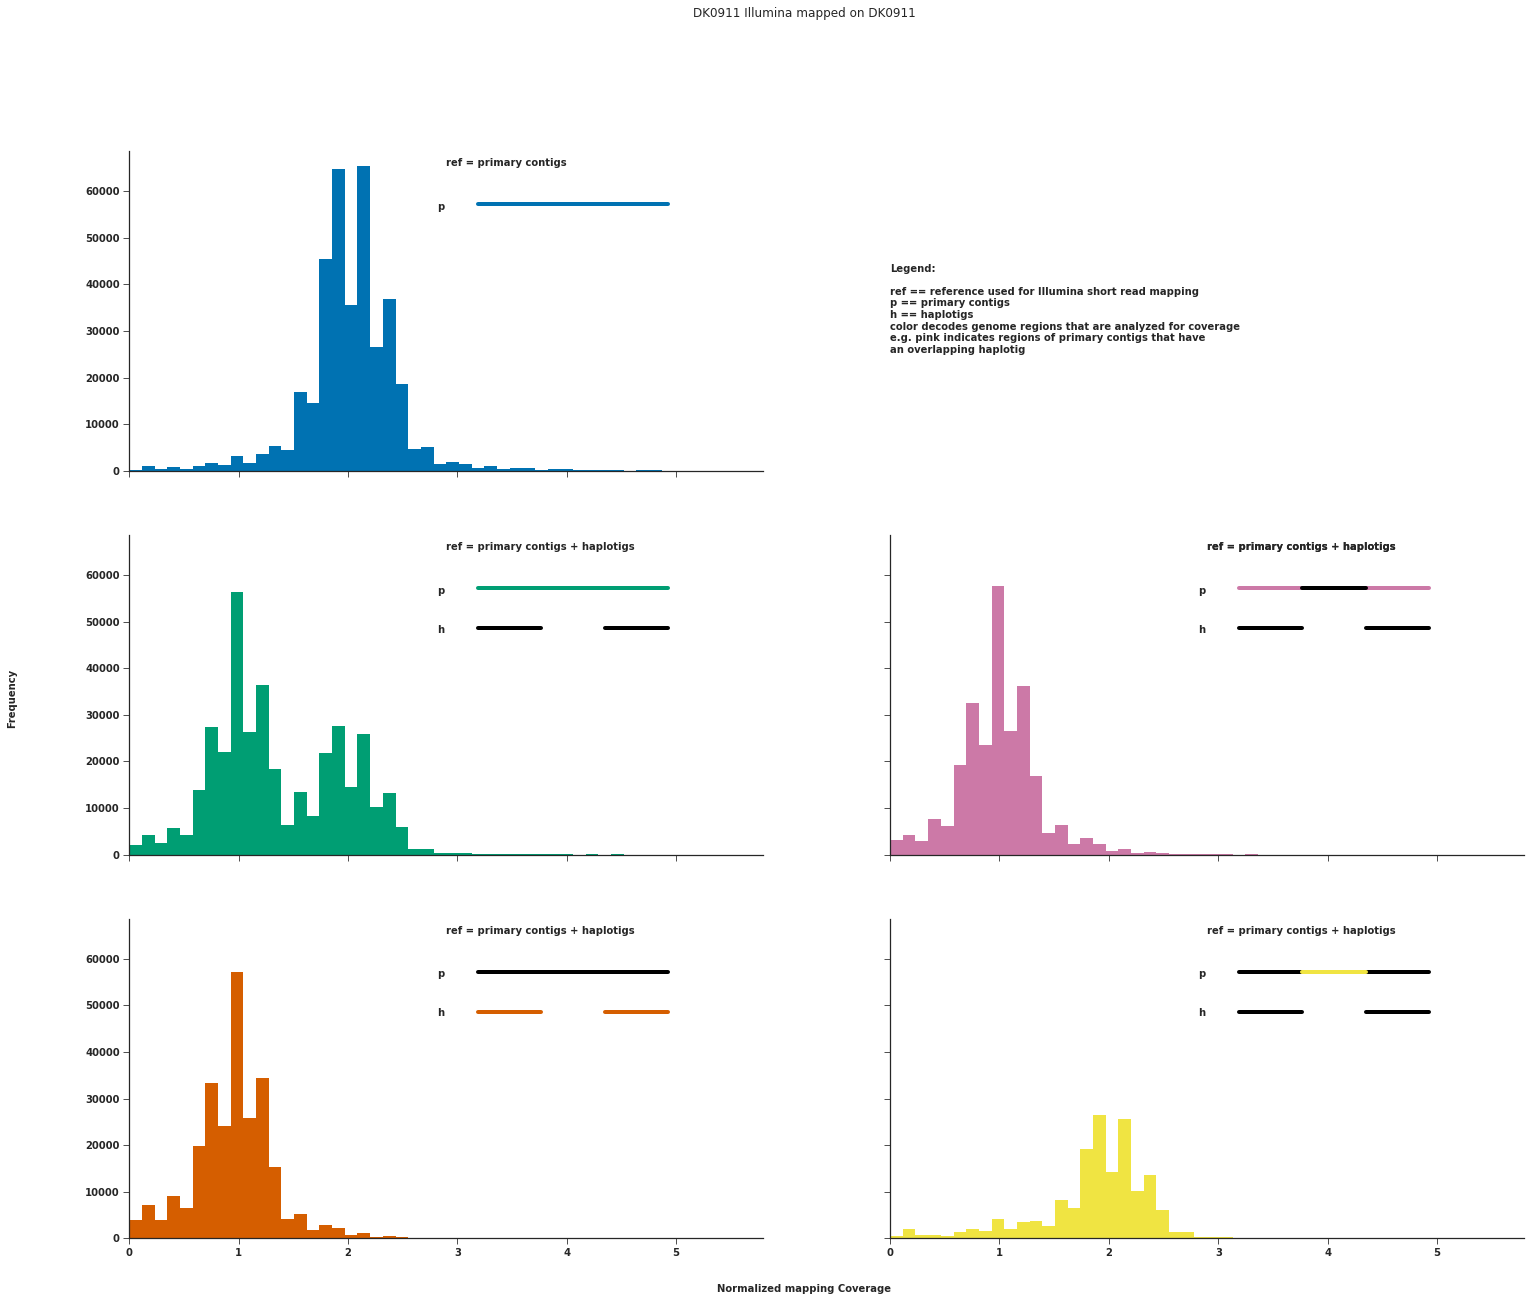

In [49]:
#now do the figure


bins =50

#
fig, ax1 = plt.subplots(3, 2, figsize=(25,20), sharex='all', sharey='all')
#set style
sns.set_style("ticks")
sns.despine()
pallete = sns.color_palette('colorblind')


ax1[0,0].hist(p_only_pm_df.norm_cov, bins=bins, color=pallete[0])

y_upper_lim = ax1[0,0].get_ylim()[1]
xstart_text = max_norm_cov/2
xincremend = max_norm_cov/20
y_upper_spot = y_upper_lim/1.2
yinremend = y_upper_lim/10

ax1[0,0].text(xstart_text, y_upper_lim/1.05, 'ref = primary contigs')
ax1[0,0].plot([xstart_text*1.1, xstart_text+(7*xincremend)], [y_upper_spot, y_upper_spot], lw =4, color = pallete[0])
ax1[0,0].text(xstart_text*0.97, y_upper_spot*0.98, 'p')
ax1[0,0].set_xlim([0,max_norm_cov])

#now plot the ph mapping with primeray mapping only

ax1[1,0].hist(p_only_phm_df.norm_cov, bins=bins, color=pallete[1])
ax1[1,0].text(xstart_text, y_upper_lim/1.05, 'ref = primary contigs + haplotigs')
ax1[1,0].plot([xstart_text*1.1, xstart_text+(7*xincremend)], [y_upper_spot, y_upper_spot], lw =4, color = pallete[1])
ax1[1,0].text(xstart_text*0.97, y_upper_spot*0.98, 'p')
ax1[1,0].plot([xstart_text*1.1, xstart_text+(3*xincremend)], [y_upper_spot*0.85, y_upper_spot*0.85], lw =4, color = 'k')
ax1[1,0].plot([xstart_text+(5*xincremend), xstart_text+(7*xincremend)], [y_upper_spot*0.85, y_upper_spot*0.85], lw =4, color = 'k')
ax1[1,0].text(xstart_text*0.97, y_upper_spot*0.98*0.85, 'h')
ax1[1,0].set_xlim([0,max_norm_cov])


#now plot the ph mapping with haplotig mapping only


ax1[2,0].hist(h_only_phm_df.norm_cov, bins=bins, color=pallete[2])
ax1[2,0].text(xstart_text, y_upper_lim/1.05, 'ref = primary contigs + haplotigs')
ax1[2,0].plot([xstart_text*1.1, xstart_text+(7*xincremend)], [y_upper_spot, y_upper_spot], lw =4, color = 'k')
ax1[2,0].text(xstart_text*0.97, y_upper_spot*0.98, 'p')
ax1[2,0].plot([xstart_text*1.1, xstart_text+(3*xincremend)], [y_upper_spot*0.85, y_upper_spot*0.85], lw =4, color = pallete[2])
ax1[2,0].plot([xstart_text+(5*xincremend), xstart_text+(7*xincremend)], [y_upper_spot*0.85, y_upper_spot*0.85], lw =4, color = pallete[2])
ax1[2,0].text(xstart_text*0.97, y_upper_spot*0.98*0.85, 'h')
ax1[2,0].set_xlim([0,max_norm_cov])


#now plot the ph mapping with primaries with overlaps
ax1[1,1].hist(p_with_h_only_phm_df.norm_cov, bins=bins, color=pallete[3])
ax1[1,1].text(xstart_text, y_upper_lim/1.05, 'ref = primary contigs + haplotigs')
ax1[1,1].text(xstart_text, y_upper_lim/1.05, 'ref = primary contigs + haplotigs')
ax1[1,1].plot([xstart_text*1.1, xstart_text+(7*xincremend)], [y_upper_spot, y_upper_spot], lw =4, color = pallete[3])
ax1[1,1].plot([xstart_text+(3*xincremend), xstart_text+(5*xincremend)],[y_upper_spot, y_upper_spot] , lw =4, color = 'k')
ax1[1,1].text(xstart_text*0.97, y_upper_spot*0.98, 'p')
ax1[1,1].plot([xstart_text*1.1, xstart_text+(3*xincremend)], [y_upper_spot*0.85, y_upper_spot*0.85], lw =4, color = 'k')
ax1[1,1].plot([xstart_text+(5*xincremend), xstart_text+(7*xincremend)], [y_upper_spot*0.85, y_upper_spot*0.85], lw =4, color = 'k')
ax1[1,1].text(xstart_text*0.97, y_upper_spot*0.98*0.85, 'h')
ax1[1,1].set_xlim([0,max_norm_cov])

#now plot the ph mapping with primaries with overlaps
ax1[2,1].hist(p_without_h_only_phm_df.norm_cov, bins=bins, color=pallete[4])

ax1[2,1].text(xstart_text, y_upper_lim/1.05, 'ref = primary contigs + haplotigs')
ax1[2,1].plot([xstart_text*1.1, xstart_text+(7*xincremend)], [y_upper_spot, y_upper_spot], lw =4, color = 'k')
ax1[2,1].plot([xstart_text+(3*xincremend), xstart_text+(5*xincremend)],[y_upper_spot, y_upper_spot] , lw =4, color = pallete[4])
ax1[2,1].text(xstart_text*0.97, y_upper_spot*0.98, 'p')
ax1[2,1].plot([xstart_text*1.1, xstart_text+(3*xincremend)], [y_upper_spot*0.85, y_upper_spot*0.85], lw =4, color = 'k')
ax1[2,1].plot([xstart_text+(5*xincremend), xstart_text+(7*xincremend)], [y_upper_spot*0.85, y_upper_spot*0.85], lw =4, color = 'k')
ax1[2,1].text(xstart_text*0.97, y_upper_spot*0.98*0.85, 'h')

ax1[2,1].set_xlim([0,max_norm_cov])

#add the labels
fig.text(0.06, 0.5, 'Frequency', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.09, 'Normalized mapping Coverage',ha='center', va='center')

#make plot [0,1] disappear
ax1[0,1].axis('off')
text = '''
Legend:\n
ref == reference used for Illumina short read mapping
p == primary contigs
h == haplotigs
color decodes genome regions that are analyzed for coverage
e.g. pink indicates regions of primary contigs that have
an overlapping haplotig
'''
ax1[0,1].text(0, y_upper_lim/3, text)
out_fn = os.path.join(OUT_PATH, '%s_SRM_coverage.png' % mapping_project)

plt.suptitle(figure_title)

#fig.savefig(out_fn, dpi=600)

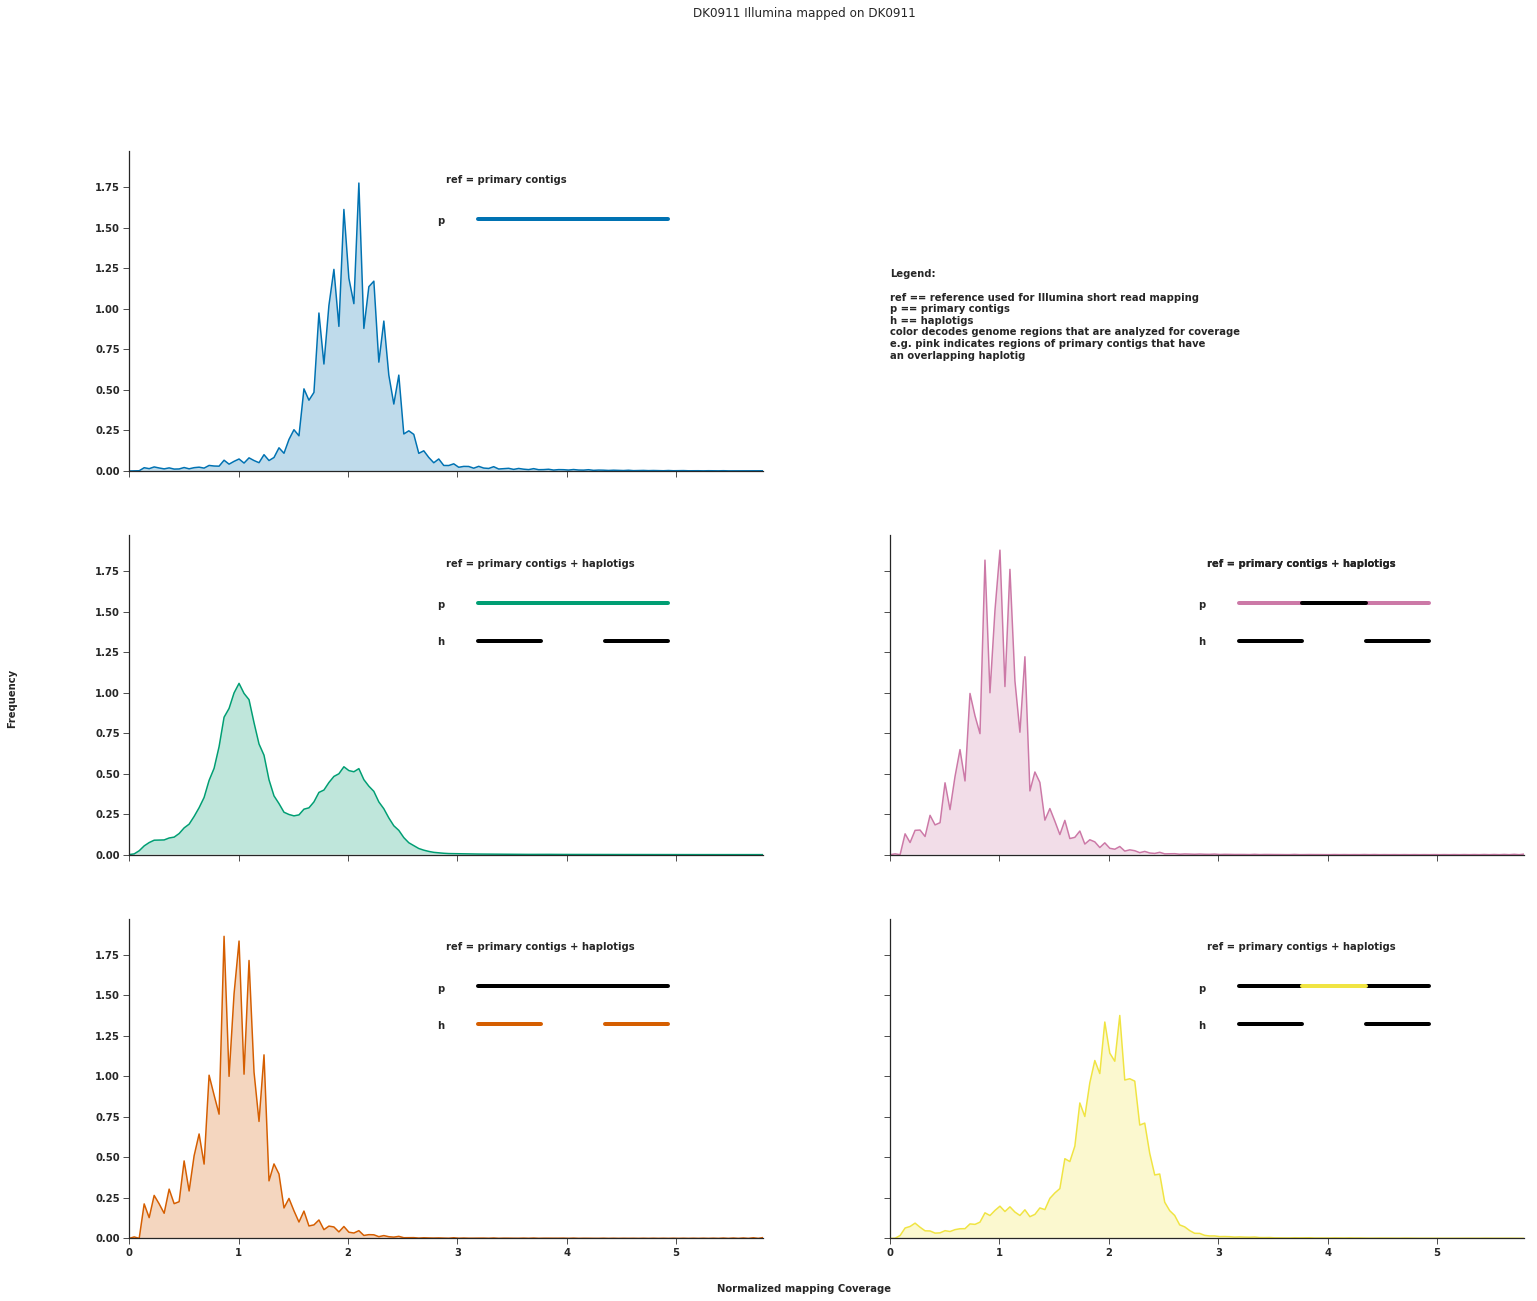

In [50]:
#now do the figure
fig, ax1 = plt.subplots(3, 2, figsize=(25,20), sharex='all', sharey='all')
#set style
sns.set_style("ticks")
sns.despine()
pallete = sns.color_palette('colorblind')
#sns.set(style="white", palette="muted", color_codes=True)

sns.kdeplot(p_only_pm_df.norm_cov, shade=True, color=pallete[0], ax=ax1[0,0], cut=0, legend=None)
#ax1[0,0].hist(p_only_pm_df.norm_cov, bins=100, color=pallete[0])

y_upper_lim = ax1[0,0].get_ylim()[1]
xstart_text = max_norm_cov/2
xincremend = max_norm_cov/20
y_upper_spot = y_upper_lim/1.2
yinremend = y_upper_lim/10

ax1[0,0].text(xstart_text, y_upper_lim/1.05, 'ref = primary contigs')
ax1[0,0].plot([xstart_text*1.1, xstart_text+(7*xincremend)], [y_upper_spot, y_upper_spot], lw =4, color = pallete[0])
ax1[0,0].text(xstart_text*0.97, y_upper_spot*0.98, 'p')
ax1[0,0].set_xlim([0,max_norm_cov])

#now plot the ph mapping with primeray mapping only

sns.kdeplot(p_only_phm_df.norm_cov, shade=True, color=pallete[1], ax=ax1[1,0], cut=0, legend=None)
ax1[1,0].text(xstart_text, y_upper_lim/1.05, 'ref = primary contigs + haplotigs')
ax1[1,0].plot([xstart_text*1.1, xstart_text+(7*xincremend)], [y_upper_spot, y_upper_spot], lw =4, color = pallete[1])
ax1[1,0].text(xstart_text*0.97, y_upper_spot*0.98, 'p')
ax1[1,0].plot([xstart_text*1.1, xstart_text+(3*xincremend)], [y_upper_spot*0.85, y_upper_spot*0.85], lw =4, color = 'k')
ax1[1,0].plot([xstart_text+(5*xincremend), xstart_text+(7*xincremend)], [y_upper_spot*0.85, y_upper_spot*0.85], lw =4, color = 'k')
ax1[1,0].text(xstart_text*0.97, y_upper_spot*0.98*0.85, 'h')
ax1[1,0].set_xlim([0,max_norm_cov])


#now plot the ph mapping with haplotig mapping only

sns.kdeplot(h_only_phm_df.norm_cov, shade=True, color=pallete[2], ax=ax1[2,0], cut=0, legend=None)
ax1[2,0].text(xstart_text, y_upper_lim/1.05, 'ref = primary contigs + haplotigs')
ax1[2,0].plot([xstart_text*1.1, xstart_text+(7*xincremend)], [y_upper_spot, y_upper_spot], lw =4, color = 'k')
ax1[2,0].text(xstart_text*0.97, y_upper_spot*0.98, 'p')
ax1[2,0].plot([xstart_text*1.1, xstart_text+(3*xincremend)], [y_upper_spot*0.85, y_upper_spot*0.85], lw =4, color = pallete[2])
ax1[2,0].plot([xstart_text+(5*xincremend), xstart_text+(7*xincremend)], [y_upper_spot*0.85, y_upper_spot*0.85], lw =4, color = pallete[2])
ax1[2,0].text(xstart_text*0.97, y_upper_spot*0.98*0.85, 'h')
ax1[2,0].set_xlim([0,max_norm_cov])


#now plot the ph mapping with primaries with overlaps
sns.kdeplot(p_with_h_only_phm_df.norm_cov, shade=True, color=pallete[3], ax=ax1[1,1], cut=0, legend=None)
ax1[1,1].text(xstart_text, y_upper_lim/1.05, 'ref = primary contigs + haplotigs')
ax1[1,1].text(xstart_text, y_upper_lim/1.05, 'ref = primary contigs + haplotigs')
ax1[1,1].plot([xstart_text*1.1, xstart_text+(7*xincremend)], [y_upper_spot, y_upper_spot], lw =4, color = pallete[3])
ax1[1,1].plot([xstart_text+(3*xincremend), xstart_text+(5*xincremend)],[y_upper_spot, y_upper_spot] , lw =4, color = 'k')
ax1[1,1].text(xstart_text*0.97, y_upper_spot*0.98, 'p')
ax1[1,1].plot([xstart_text*1.1, xstart_text+(3*xincremend)], [y_upper_spot*0.85, y_upper_spot*0.85], lw =4, color = 'k')
ax1[1,1].plot([xstart_text+(5*xincremend), xstart_text+(7*xincremend)], [y_upper_spot*0.85, y_upper_spot*0.85], lw =4, color = 'k')
ax1[1,1].text(xstart_text*0.97, y_upper_spot*0.98*0.85, 'h')
ax1[1,1].set_xlim([0,max_norm_cov])

#now plot the ph mapping with primaries with overlaps

sns.kdeplot(p_without_h_only_phm_df.norm_cov, shade=True, color=pallete[4], ax=ax1[2,1], cut=0, legend=None)
ax1[2,1].text(xstart_text, y_upper_lim/1.05, 'ref = primary contigs + haplotigs')
ax1[2,1].plot([xstart_text*1.1, xstart_text+(7*xincremend)], [y_upper_spot, y_upper_spot], lw =4, color = 'k')
ax1[2,1].plot([xstart_text+(3*xincremend), xstart_text+(5*xincremend)],[y_upper_spot, y_upper_spot] , lw =4, color = pallete[4])
ax1[2,1].text(xstart_text*0.97, y_upper_spot*0.98, 'p')
ax1[2,1].plot([xstart_text*1.1, xstart_text+(3*xincremend)], [y_upper_spot*0.85, y_upper_spot*0.85], lw =4, color = 'k')
ax1[2,1].plot([xstart_text+(5*xincremend), xstart_text+(7*xincremend)], [y_upper_spot*0.85, y_upper_spot*0.85], lw =4, color = 'k')
ax1[2,1].text(xstart_text*0.97, y_upper_spot*0.98*0.85, 'h')

ax1[2,1].set_xlim([0,max_norm_cov])

#add the labels
fig.text(0.06, 0.5, 'Frequency', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.09, 'Normalized mapping Coverage',ha='center', va='center')

#make plot [0,1] disappear
ax1[0,1].axis('off')
text = '''
Legend:\n
ref == reference used for Illumina short read mapping
p == primary contigs
h == haplotigs
color decodes genome regions that are analyzed for coverage
e.g. pink indicates regions of primary contigs that have
an overlapping haplotig
'''
ax1[0,1].text(0, y_upper_lim/3, text)
out_fn = os.path.join(OUT_PATH, '%s_SRM_coverage.png' % mapping_project)

plt.suptitle(figure_title)

#fig.savefig(out_fn, dpi=600)

In [55]:
max_norm_cov = 4
p_only_pm_df = filter_on_norm_cov(samcov_slurp(samcov_list[0], quantile = 0.98, norm = p_only_phm_haploid_cov))
p_only_phm_df = filter_on_norm_cov(samcov_slurp(samcov_list[1], fil = True, low =0, high = max_ave_cov , norm = p_only_phm_haploid_cov, contig_fil='p'))
h_only_phm_df = filter_on_norm_cov(samcov_slurp(samcov_list[1], fil = True, low =0, high = max_ave_cov , norm = p_only_phm_haploid_cov, contig_fil='h'))
p_with_h_only_phm_df = filter_on_norm_cov(samcov_slurp(samcov_list[2], fil = True, low =0, high = max_ave_cov , norm = p_only_phm_haploid_cov, contig_fil='p'))
p_without_h_only_phm_df = filter_on_norm_cov(samcov_slurp(samcov_list[3], fil = True, low =0, high = max_ave_cov , norm = p_only_phm_haploid_cov, contig_fil='p'))

p_only_pm_df_cut = bin_value_filter_df(p_only_pm_df)
df_to_tab(p_only_pm_df_cut, os.path.join(COMB_OUT, '%s.p_pm.bvf.df' % mapping_project))
p_only_phm_df_cut = bin_value_filter_df(p_only_phm_df)
df_to_tab(p_only_phm_df_cut, os.path.join(COMB_OUT, '%s.p_phm.bvf.df' % mapping_project))
h_only_phm_df_cut = bin_value_filter_df(h_only_phm_df)
df_to_tab(h_only_phm_df_cut, os.path.join(COMB_OUT, '%s.h_phm.bvf.df' % mapping_project))
p_with_h_only_phm_df_cut = bin_value_filter_df(p_with_h_only_phm_df)
df_to_tab(p_with_h_only_phm_df_cut, os.path.join(COMB_OUT, '%s.pwh_phm.bvf.df' % mapping_project))
p_without_h_only_phm_df_cut = bin_value_filter_df(p_without_h_only_phm_df)
df_to_tab(p_without_h_only_phm_df_cut, os.path.join(COMB_OUT, '%s.pwoh_phm.bvf.df' % mapping_project))

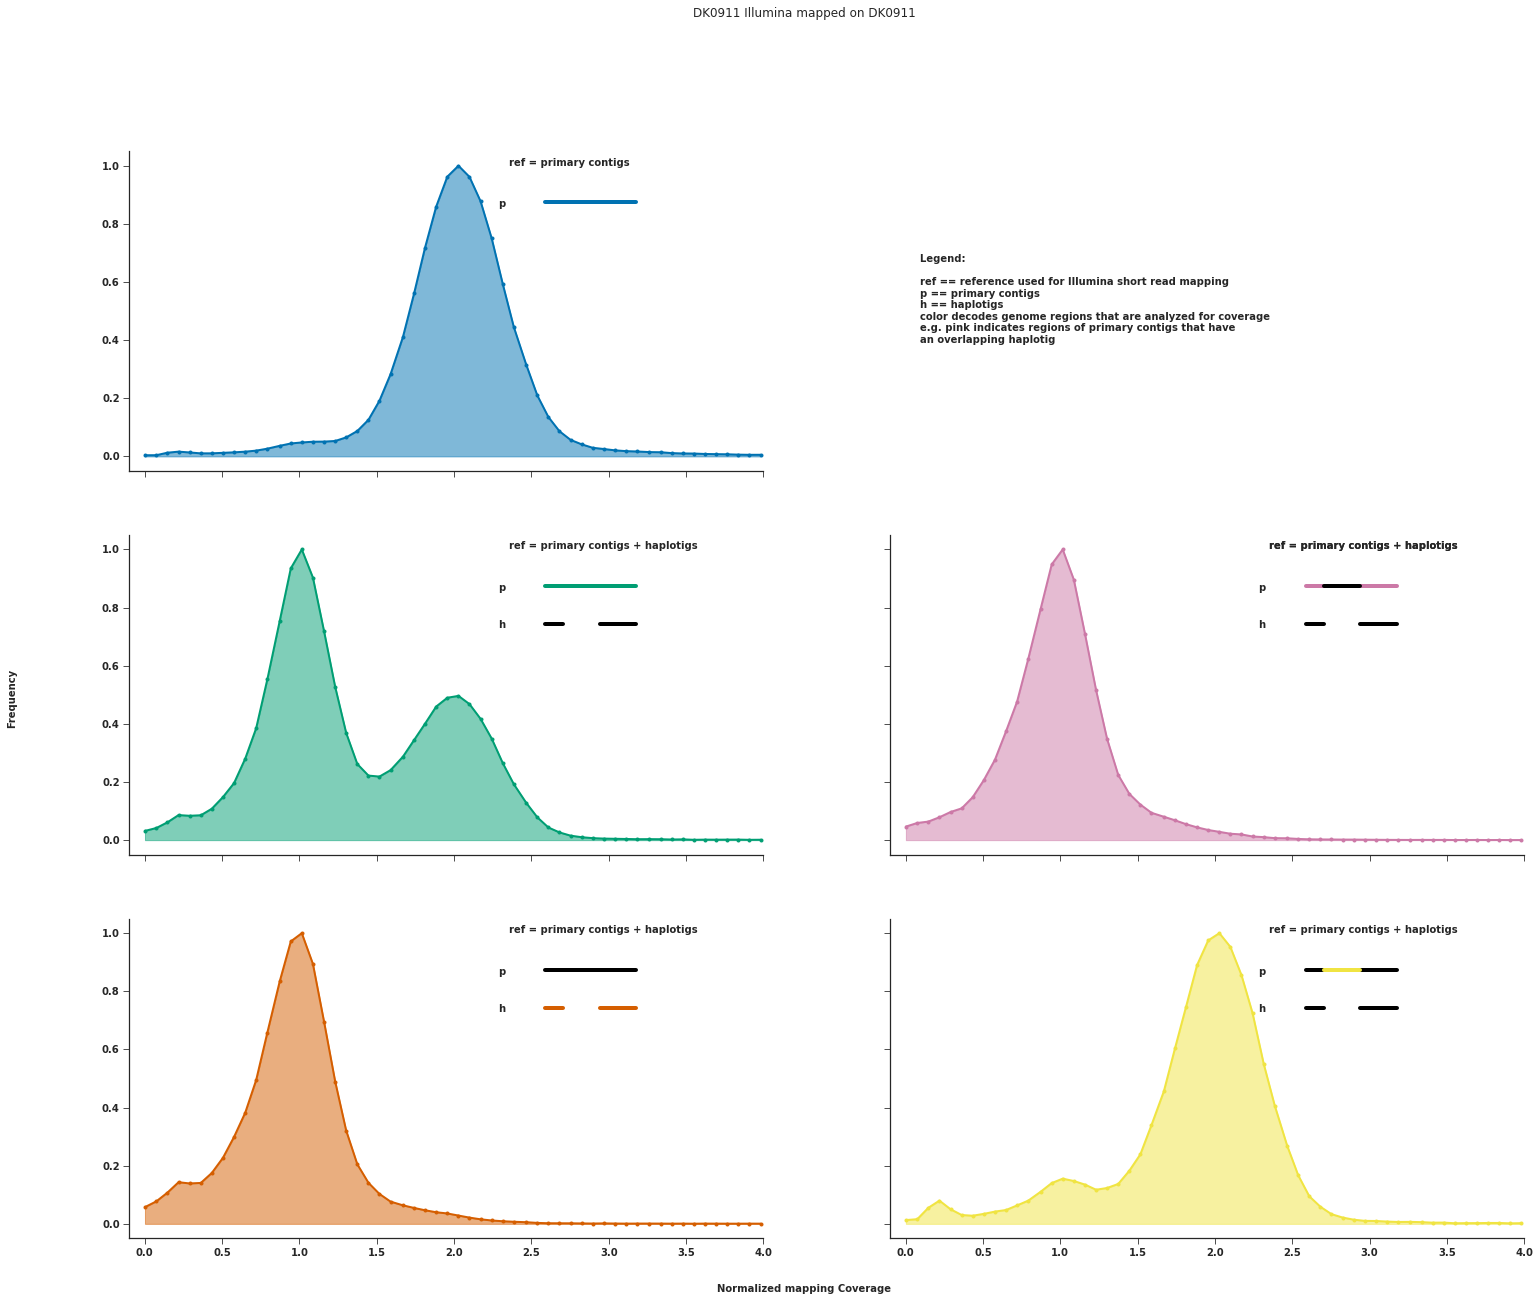

In [52]:
#now do the figure
fig, ax1 = plt.subplots(3, 2, figsize=(25,20), sharex='all', sharey='all')
#set style
sns.set_style("ticks")
sns.despine()
pallete = sns.color_palette('colorblind')
#sns.set(style="white", palette="muted", color_codes=True)

fill_plot_axis(list(p_only_pm_df_cut.mids), list(p_only_pm_df_cut.norm_freq), color=pallete[0], ax=ax1[0,0])
fill_plot_axis(list(p_only_phm_df_cut.mids), list(p_only_phm_df_cut.norm_freq), color=pallete[1], ax=ax1[1,0])
fill_plot_axis(list(h_only_phm_df_cut.mids), list(h_only_phm_df_cut.norm_freq), color=pallete[2], ax=ax1[2,0])
fill_plot_axis(list(p_with_h_only_phm_df_cut.mids), list(p_with_h_only_phm_df_cut.norm_freq), color=pallete[3], ax=ax1[1,1])
fill_plot_axis(list(p_without_h_only_phm_df_cut.mids), list(p_without_h_only_phm_df_cut.norm_freq), color=pallete[4], ax=ax1[2,1])



y_upper_lim = ax1[0,0].get_ylim()[1]
xstart_text = max_norm_cov/1.7
plot_mapping_annotation(fig, ax1, pallete=pallete, y_upper_lim = y_upper_lim, xstart_text=xstart_text)

ax1[0,0].set_xlim([-0.1,4])

out_fn = os.path.join(OUT_PATH, '%s_SRM_coverage.png' % mapping_project)

plt.suptitle(figure_title)

#fig.savefig(out_fn, dpi=600)

In [44]:
#quickly make a h_genome file
h_genome_file_fn = ph_genome_file_fn.replace('_ph_', '_h_')
command = 'grep "^hcontig" %s > %s' %(ph_genome_file_fn, h_genome_file_fn)
run_command(command)

p_window_1k_bed = BedTool().window_maker(g=p_genome_file_fn, w=1000)
ph_window_1k_bed = BedTool().window_maker(g=ph_genome_file_fn, w=1000)
h_window_1k_bed = BedTool().window_maker(g=h_genome_file_fn, w=1000)
min_norm_cov_cutoff = 0.05

p_lowcov_bed_fn = df_to_bed_saved(samcov_slurp(samcov_list[0], norm = p_only_phm_haploid_cov, fil=False), min_norm_cov_cutoff, samcov_list[0])
ph_lowcov_bed_fn = df_to_bed_saved(samcov_slurp(samcov_list[1], norm = p_only_phm_haploid_cov, fil=False), min_norm_cov_cutoff, samcov_list[1])
h_on_p_ph_mapping_lowcov_bed_fn = df_to_bed_saved(samcov_slurp(samcov_list[2], norm = p_only_phm_haploid_cov, fil=False), min_norm_cov_cutoff, samcov_list[2])
h_not_on_p_ph_mapping_lowcov_bed_fn = df_to_bed_saved(samcov_slurp(samcov_list[3], norm = p_only_phm_haploid_cov, fil=False), min_norm_cov_cutoff, samcov_list[3])

print('This is the number of bases in the lowcov regions for primary contigs when doing p mappping: %i' % count_bases_in_bed(p_lowcov_bed_fn))

print('This is the number of bases in lowcov regions for primary contigs and haplotig when doing ph mapping: %i' % count_bases_in_bed(ph_lowcov_bed_fn))

print('This is the number of bases in the lowcov regions for primary contigs with haplotig overlap when doing ph mapping: %i' % count_bases_in_bed(h_on_p_ph_mapping_lowcov_bed_fn))

print('This is the number of bases in the lowcov regions for primary contigs without haplotig overlap when doing ph mapping: %i' % count_bases_in_bed(h_not_on_p_ph_mapping_lowcov_bed_fn))


Runnning now!

grep "^hcontig" /home/benjamin/genome_assembly/Warrior/genome_v04/DK_0911_v04_ph_ctg.genome_file > /home/benjamin/genome_assembly/Warrior/genome_v04/DK_0911_v04_h_ctg.genome_file

Done
With ouput:
b''
b''
This is the number of bases in the lowcov regions for primary contigs when doing p mappping: 57850
This is the number of bases in lowcov regions for primary contigs and haplotig when doing ph mapping: 979815
This is the number of bases in the lowcov regions for primary contigs with haplotig overlap when doing ph mapping: 376758
This is the number of bases in the lowcov regions for primary contigs without haplotig overlap when doing ph mapping: 32597


In [ ]:
p_only_pm_df_cut.columns